# Análisis estadístico e inferencial

En este notebook vamos a realizar análisis estadísticos más avanzados, pues la parte de estadística descriptiva ya está icluida en el EDA. Aquí incluiremos la parte de estadística inferencial.

**Objetivos:**
- Comparar interacciones según variables clave (tipo, promoción, etc.)
- Realizar contrastes de hipótesis
- Explorar relaciones predictivas mediante regresión


## Importación de librerías

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, shapiro, levene
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve, auc
import scipy.stats as stats
from scipy.stats import kruskal
import scikit_posthocs as sp
from scipy.stats import mannwhitneyu



## Carga de datos y revisión inicial

In [2]:
viral_path = "/Users/elena/Downloads/Data_science/proyectos/proyecto_I/interacciones-Facebook/data/dataset_viral.csv"
df = pd.read_csv(viral_path, sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   page_total_likes                                                     500 non-null    int64  
 1   type                                                                 500 non-null    object 
 2   post_month                                                           500 non-null    int64  
 3   post_weekday                                                         500 non-null    int64  
 4   post_hour                                                            500 non-null    int64  
 5   paid                                                                 500 non-null    float64
 6   lifetime_post_total_reach                                            500 non-null    int64  
 7   lifetime

In [3]:
cat_columns = ['post_month', 'post_weekday', 'post_hour', 'paid']
for col in cat_columns:
    df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column                                                               Non-Null Count  Dtype   
---  ------                                                               --------------  -----   
 0   page_total_likes                                                     500 non-null    int64   
 1   type                                                                 500 non-null    object  
 2   post_month                                                           500 non-null    category
 3   post_weekday                                                         500 non-null    category
 4   post_hour                                                            500 non-null    category
 5   paid                                                                 500 non-null    category
 6   lifetime_post_total_reach                                            500 non-null    int64   
 7  

## Contraste de hipótesis: Efecto de la promoción en las interacciones

En el EDA anterior, vimos dos boxplot de Interacciones promedio según si el post fue promocionado o no. De su observación concluimos que as publicaciones promocionadas presentan un promedio de interacciones más alto que las publicaciones no promocionadas, pero también muestran una mayor dispersión. Ahora vamos a comprobarlo con un contraste de hipótesis:

**Hipótesis nula (H₀)**: las publicaciones promocionadas y no promocionadas tienen la misma media de interacciones.

**Hipótesis alternativa (H₁)**: las publicaciones promocionadas tienen una media de interacciones superior.


In [4]:
# primero separamos las interacciones totales en dos muestras: una con post promocionados y otra de orgánicos
promo = df[df['paid'] == 1]['total_interactions']
no_promo = df[df['paid'] == 0]['total_interactions']

# ahora hacemos el test de Shapiro, que comprueba si las muestras tienen una distribución normal o no
print("Shapiro-Wilk test (promocionadas):", shapiro(promo))
print("Shapiro-Wilk test (no promocionadas):", shapiro(no_promo))

Shapiro-Wilk test (promocionadas): ShapiroResult(statistic=np.float64(0.32689308125893246), pvalue=np.float64(1.5127955993799125e-22))
Shapiro-Wilk test (no promocionadas): ShapiroResult(statistic=np.float64(0.5691011678434302), pvalue=np.float64(6.799386403005929e-29))


Los p-valores están muy por debajo de 0.05 (1.51e-22 y 6.79e-29). Por tanto, se rechaza la hipótesis nula (la muestra sigue una distribución normal) en ambos casos.

Esto significa que no se cumple el supuesto de normalidad necesario para el uso del t-test clásico (paramétrico).

Vamos a utilizar el t-tes de Welch, que es bastante robusto, pero como las muestras no son normales, puede afectar a su validez, por tanto, también realizaremos un test no paramétrico, el test de Mann-Whitney, que compara las medias/medianas entre las dos muestras

In [5]:
# vamos a comprobar ahora si las varianzas son iguales o no, para incluirlo en el tes de Welch
print("Levene test:", levene(promo, no_promo))

Levene test: LeveneResult(statistic=np.float64(4.003707243982035), pvalue=np.float64(0.045942542397630924))


Hemos obtenido un p-valor de 0.0459, que está por debajo de 0.05, por tanto rechazamos la hipótesis nula (varianzas iguales entre las muestras) y asumimos que las varianzas son diferentes.

In [6]:
# t-test de Welch con varianzas desiguales (equal_var=False)
t_stat, p_val = ttest_ind(promo, no_promo, equal_var=False)
print(f"T-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")

T-statistic = 1.7579, p-value = 0.0807


Hemos obtenido un p-valor de 0.0807, que es mayor que 0.05, por tanto no hay suficiente evidencia estadística para rechazar que las publicaciones promocionadas tengan iuna media de interacciones diferentes a las no promocionadas.

Recordemos que nuestras muestras incumplían la condición de normalidad, así que vamos a ver qué concluiríamos ahora con el test no paraméttrico de Mann-Whitney:

In [7]:
stat, p = mannwhitneyu(promo, no_promo, alternative='two-sided')
print(f"U-statistic = {stat}, p-value = {p}")

U-statistic = 28846.0, p-value = 0.00945827744412867


Aquí vemos que el p-valor (0.009458) es < 0.05, entonces se rechaza la hipótesis nula y se concluye que hay diferencias estadísticamente significativas en las interacciones entre publicaciones promocionadas y no promocionadas. 

Dado que los datos no son normales, esta prueba proporciona una comparación más robusta entre grupos. Por lo tanto, asumimos que las interacciones cuando una publicación está promocionada son superiores estadísticamente.

## Contraste de hipótesis 2: ¿Hay diferencias significativas entre días de la semana?

En el EDA anterior, también vimos que parece no haber una diferencia significativa en las interacciones según el día de la semana que se publique el post. Vamos a comprobarlo con un ANOVA o análisis de la varianza.

**Hipótesis nula (H₀)**: La media de interacciones es igual para todos los días.

**Hipótesis alternativa (H₁)**: Al menos un día tiene una media diferente.

In [20]:
# verificamos normalidad para cada día de la semana 
for day in df['post_weekday'].unique():
    print(f"Día {day}:")
    stat, p = stats.shapiro(df[df['post_weekday'] == day]['total_interactions'])
    print(f"  Shapiro-Wilk p-value: {p:.4f}")

Día 4:
  Shapiro-Wilk p-value: 0.0000
Día 3:
  Shapiro-Wilk p-value: 0.0000
Día 2:
  Shapiro-Wilk p-value: 0.0000
Día 1:
  Shapiro-Wilk p-value: 0.0000
Día 7:
  Shapiro-Wilk p-value: 0.0000
Día 6:
  Shapiro-Wilk p-value: 0.0000
Día 5:
  Shapiro-Wilk p-value: 0.0000


In [21]:
# levene's test para igualdad de varianzas
groups = [df[df['post_weekday'] == day]['total_interactions'] for day in df['post_weekday'].unique()]
stat, p = stats.levene(*groups)
print(f"Levene’s test p-value: {p:.4f}")


Levene’s test p-value: 0.4760


Estos valores de p < 0.0001 en el test de Shapiro-Wilk en todos los días de la semana indican qque la distribución de interacciones no es normal en ningún grupo de días. El resultado del Levene’s test con un p-value de 0.4760 indica que no se rechaza la hipótesis nula de igualdad de varianzas. Es decir:

- La normalidad no se cumple en ningún grupo (Shapiro-Wilk p < 0.0001).
- La homogeneidad de varianzas sí se cumple (Levene’s p = 0.4760).

Aunque las varianzas son homogéneas, el incumplimiento de normalidad en todos los grupos sigue siendo un problema grave, por tanto NO utilizaremos un análisis ANOVA. En su lugar, utilizaremos el test de Kruskal-Wallis, que no necesita asumir normalidad.

In [23]:
# agrupamos las interacciones por día de la semana
grouped = [group['total_interactions'].values for name, group in df.groupby('post_weekday')]

# aplicamos el test de Kruskal-Wallis
stat, p = kruskal(*grouped)

print(f"Estadístico de Kruskal-Wallis: {stat:.4f}")
print(f"Valor p: {p:.4f}")


Estadístico de Kruskal-Wallis: 16.7948
Valor p: 0.0101


/var/folders/gs/26000r592n9fn9v0kpbm0z5m0000gp/T/ipykernel_46981/4244000449.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = [group['total_interactions'].values for name, group in df.groupby('post_weekday')]


Dado que p < 0.05, se concluye que hay diferencias significativas en las interacciones totales entre al menos dos días de la semana.

Sin embargo, el test de Kruskal-Wallis no indica entre qué grupos específicos están esas diferencias. Para saberlo, necesitamos realizar un análisis post-hoc.

In [25]:
# aplicamos el test de Dunn con corrección de Holm (o Bonferroni)
posthoc_dunn = sp.posthoc_dunn(
    df, 
    val_col='total_interactions', 
    group_col='post_weekday', 
    p_adjust='holm'
)

# matriz de comparaciones múltiples
posthoc_dunn


,1,2,3,4,5,6,7
1,1.000000,1.000000,1.00000,0.153907,1.0,1.00000,1.000000
2,1.000000,1.000000,1.00000,0.669519,1.0,1.00000,1.000000
3,1.000000,1.000000,1.00000,0.255770,1.0,1.00000,1.000000
4,0.153907,0.669519,0.25577,1.000000,1.0,0.03124,0.003953
5,1.000000,1.000000,1.00000,1.000000,1.0,1.00000,1.000000
6,1.000000,1.000000,1.00000,0.031240,1.0,1.00000,1.000000
7,1.000000,1.000000,1.00000,0.003953,1.0,1.00000,1.000000


- Cada celda contiene el p-valor ajustado de la comparación entre dos días.
- Valores < 0.05 indican que esos dos días tienen distribuciones significativamente diferentes en cuanto a interacciones.

### Resultados significativos (p < 0.05):

-  Día 4 (jueves) vs. Día 6 (sábado): p = 0.0312
-  Día 4 (jueves) vs. Día 7 (domingo): p = 0.0039

- Las publicaciones en jueves generan más interacciones** que en sábado o domingo, de forma estadísticamente significativa.
- No se encontraron diferencias relevantes entre el resto de los días.

## Contraste de hipótesis 3: Diferencias de interacciones según el tipo de interacción.

De nuevo, también vimos en el EDA con boxplots que los post en formato vídeo eran los que tenían una mayor mediana de interacciones, aunque las fotos eran las que tenían un mayor número de casos virales. Vamos a comprobar con otro ANOVA si existe una diferencia significativa.

**Hipótesis nula (H₀)**: La media de interacciones es igual para todos los tipos de post.

**Hipótesis alternativa (H₁)**: Al menos un tipo de post tiene una media significativamente diferente.

In [26]:
for t in df['type'].unique():
    print(f"Tipo: {t}")
    stat, p = shapiro(df[df['type'] == t]['total_interactions'])
    print(f"  Shapiro-Wilk p-value: {p:.4f}")

Tipo: Photo
  Shapiro-Wilk p-value: 0.0000
Tipo: Status
  Shapiro-Wilk p-value: 0.0000
Tipo: Link
  Shapiro-Wilk p-value: 0.0002
Tipo: Video
  Shapiro-Wilk p-value: 0.5242


In [27]:
# agrupamos por tipo de post
groups_by_type = [group['total_interactions'].values for name, group in df.groupby('type')]

# Levene's test
stat, p = levene(*groups_by_type)
print(f"Levene’s test p-value: {p:.4f}")

Levene’s test p-value: 0.6682


Levene’s test:
- p = 0.6682 -> no se rechaza la igualdad de varianzas -> confirmamos la homogeneidad de varianzas

Shapiro-Wilk:
- Photo, Status y Link tienen p < 0.05 -> no cumplen normalidad
- Solo Video tiene p > 0.05

Por tanto, el supuesto de normalidad no se cumple para la mayoría de los grupos. Aunque las varianzas son homogéneas, la ausencia de normalidad nos obliga a usar un test no paramétrico: test de Kruskal-Wallis por tipo de interacción


In [28]:
# agrupamos las interacciones por tipo de post
groups_by_type = [group['total_interactions'].values for name, group in df.groupby('type')]

# Test de Kruskal-Wallis
stat, p = kruskal(*groups_by_type)
print(f"Estadístico de Kruskal-Wallis: {stat:.4f}")
print(f"Valor p: {p:.4f}")

Estadístico de Kruskal-Wallis: 20.1978
Valor p: 0.0002


Como p < 0.05, hay diferencias estadísticamente significativas en las interacciones totales entre al menos dos tipos de publicación (Photo, Status, Link, Video).

Ahora, como hicimos antes, aplicamos un análisis post-hoc con la prueba de Dunn, para saber entre qué tipos de post existen diferencias.

In [29]:
# Post-hoc Dunn con corrección de Holm
posthoc_dunn_type = sp.posthoc_dunn(
    df,
    val_col='total_interactions',
    group_col='type',
    p_adjust='holm'
)

posthoc_dunn_type

,Link,Photo,Status,Video
Link,1.000000,0.005043,0.000281,0.004898
Photo,0.005043,1.000000,0.071778,0.113927
Status,0.000281,0.071778,1.000000,0.360672
Video,0.004898,0.113927,0.360672,1.000000


### Comparaciones significativas (p < 0.05):
- `Link` vs. `Photo`: p = 0.0050
- `Link` vs. `Status`: p = 0.0003
- `Link` vs. `Video`: p = 0.0049

- El tipo de publicación `Link` obtiene significativamente menos interacciones que los demás tipos (`Photo`, `Status`, `Video`).
- No hay diferencias estadísticamente significativas entre `Photo`, `Status` y `Video`.

> Esta información puede ayudar a optimizar la estrategia de contenido: **evitar posts tipo Link si el objetivo es maximizar la interacción.**

## Elección del modelo

En un primer momento, queríamos crear un modelo de regresión lineal que predijera el total de interacciones en función de otras variables. Pero como vimos en la matriz de correlación del notebook anterior, esta variable solo tiene una correlación lineal fuerte positiva con comment, like y share. Son las únicas variables que cuentan con una correlación superior en valor absoluto a 0.75. No obstante, vamos a descartar este modelo, ya que la variable total de interacciones se calcula como la suma de las otras tres, por lo que no tendría sentido crear un modelo de regresión lineal con la variable `total_interactions` como variable dependiente.


Tras observar que algunas publicaciones tienen un número de interacciones muy por encima del promedio, hemos creado una variable llamada `viral`, que toma el valor 1 si el post se encuentra por encima del percentil 95 en `total_interactions`, y 0 en caso contrario.
Partiendo de esta variable, podemos crear un modelo cuyo objetivo sea predecir la probabilidad de que una publicación sea viral en función de ciertas características (hora, tipo de post, promoción, etc.). Como La variable `viral` es binaria (0 o 1), por lo tanto, no se puede modelar adecuadamente con regresión lineal, crearemos entonces un modelo de regresión logística.

## Modelo de regresión logística: predicción de publicaciones virales

Vamos a generar un modelo que nos permitirá entender **qué factores aumentan o reducen la probabilidad de que un post se vuelva viral**.

In [11]:
# nos aseguramos de  que la variable viral está bien definida como binaria
df['viral'] = df['viral'].astype(int)


# vamos a dividir post_hour en c: mañana (06:00 - 11:59), tarde (12:00 - 17:59), tarde_noche (18:00 - 23:59) y noche (00:00 -05:59) 
# ponemos la variable como numérica
df['post_hour'] = df['post_hour'].astype(int)

# creamos la nueva columna post_period
def agrupar_periodo(hora):
    if hora < 6:
        return "noche"
    elif hora < 12:
        return "mañana"
    elif hora < 18:
        return "tarde"
    else:
        return "tarde_noche"

df['post_period'] = df['post_hour'].apply(agrupar_periodo)
df['post_period'] = df['post_period'].astype('category')

# verificamos que se ha hecho bien
df['post_period'].value_counts()

post_period
noche          196
mañana         193
tarde          104
tarde_noche      7
Name: count, dtype: int64

In [12]:
# ajustamos el modelo de regresión logística
logit_model = smf.logit("viral ~ C(type) + C(post_month) + C(post_period) + C(post_weekday) + C(paid) + lifetime_post_total_reach", data=df).fit()

#resumen del modelo
logit_model.summary()

         Current function value: 0.127186
         Iterations: 35


/Users/elena/Desktop/miniconda3/envs/entornop1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  viral   No. Observations:                  500
Model:                          Logit   Df Residuals:                      474
Method:                           MLE   Df Model:                           25
Date:                Tue, 08 Apr 2025   Pseudo R-squ.:                  0.3593
Time:                        22:21:53   Log-Likelihood:                -63.593
converged:                      False   LL-Null:                       -99.258
Covariance Type:            nonrobust   LLR p-value:                 2.437e-06
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -25.0703   2.31e+04     -0.001      0.999   -4.53e+04    4.52e+04
C(type)[T.Photo]                 21.4802   2.31e+04      0.001      0.999   -4.52e+04    4.52e+04
C(type)[T.Status]                20.5333   2.31e+04      0.001      0.999   -4.52e+04    4.52e+04
C(type)[T.Video]                  0.6780   2.47e+04   2.75e-05      1.000   -4.84e+04    4.84e+04
C(post_month)[T.2]               -4.7661      2.310     -2.063      0.039      -9.293      -0.239
C(post_month)[T.3]               -2.7319      1.937     -1.410      0.158      -6.528       1.065
C(post_month)[T.4]               -2.2308      1.683     -1.325      0.185      -5.530       1.068
C(post_month)[T.5]                0.3851      1.332      0.289      0.772      -2.225       2.995
C(post_month)[T.6]               -2.4467      1.645     -1.488      0.137      -5.670       0.777
C(post_month)[T.7]               -0.7638      1.315     -0.581      0.561      -3.341       1.814
C(post_month)[T.8]                0.5680      1.276      0.445      0.656      -1.932       3.069
C(post_month)[T.9]                0.8127      1.327      0.612      0.540      -1.788       3.414
C(post_month)[T.10]               0.2521      1.306      0.193      0.847      -2.308       2.812
C(post_month)[T.11]              -0.8139      1.520     -0.535      0.592      -3.794       2.166
C(post_month)[T.12]               0.7957      1.275      0.624      0.533      -1.703       3.294
C(post_period)[T.noche]           0.7260      0.598      1.215      0.224      -0.445       1.897
C(post_period)[T.tarde]           1.1404      0.777      1.468      0.142      -0.382       2.663
C(post_period)[T.tarde_noche]   -17.5837   5.04e+04     -0.000      1.000   -9.88e+04    9.88e+04
C(post_weekday)[T.2]             -1.5642      0.951     -1.645      0.100      -3.428       0.300
C(post_weekday)[T.3]             -1.4416      0.977     -1.475      0.140      -3.357       0.474
C(post_weekday)[T.4]             -0.4173      0.774     -0.539      0.590      -1.935       1.101
C(post_weekday)[T.5]             -0.2232      0.800     -0.279      0.780      -1.792       1.346
C(post_weekday)[T.6]             -1.5689      1.026     -1.528      0.126      -3.581       0.443
C(post_weekday)[T.7]             -2.0158      1.058     -1.906      0.057      -4.089       0.057
C(paid)[T.1.0]                    0.1657      0.543      0.305      0.760      -0.898       1.229
lifetime_post_total_reach      5.817e-05   1.07e-05      5.455      0.000    3.73e-05    7.91e-05
=================================================================================================
"""

##### Interpretación del resultado
- **Pseudo R-squared = 0.3593** . Tenemos un 36% de mejora sobre el modelo nulo: estamos tratando datos sociales, por lo que vamos a darlo como aceptable.

- **LLR p-value = 2.437e-06** . Este p-valor < 0.05 indica que, en conjunto, las variables aportan información significativa al modelo.

- **converged: False** ¡El modelo no ha convergido! Los coeficientes pueden no ser fiables aún.


¿Por qué puede no converger?
1. Multicolinealidad: puede haber variables muy correlacionadas.
2. Categorías poco frecuentes en alguna dummy -> no hay suficiente información para estimar bien su efecto.
3. Modelo demasiado complejo (25 parámetros para 500 observaciones).

Vamos a probar a eliminar alguna variable del modelo:

In [13]:
logit_model2 = smf.logit("viral ~ C(paid)", data=df).fit()
logit_model2.summary()

Optimization terminated successfully.
         Current function value: 0.196693
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  viral   No. Observations:                  500
Model:                          Logit   Df Residuals:                      498
Method:                           MLE   Df Model:                            1
Date:                Tue, 08 Apr 2025   Pseudo R-squ.:                0.009178
Time:                        22:22:33   Log-Likelihood:                -98.347
converged:                       True   LL-Null:                       -99.258
Covariance Type:            nonrobust   LLR p-value:                    0.1771
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.1384      0.264    -11.900      0.000      -3.655      -2.621
C(paid)[T.1.0]     0.5812      0.421      1.380      0.168      -0.244       1.406
==================================================================================
"""

Después de probar todas las combinaciones posibles entre las variables independientes, solo este modelo ha convergido. Pero no nos gusta que la viralidad solo dependa de si la publicación está promocionada o no. Ademas tenemos un p-valor superior a 0.05 y tan solo un 0.92% de mejora respecto al modelo nulo. Vamos a rechazar este modelo y buscar otras alternativas.

## Cambio de modelo: de regresión logística clásica a regresión logística penalizada

Durante el desarrollo del modelo de regresión logística, hemos identificado varios problemas que impedían su convergencia. Ante esto, hemos optado por un enfoque más robusto usando `scikit-learn`, que permite ajustar una regresión logística con regularización L2 (Ridge).

Este modelo penaliza los coeficientes grandes, entonces:
- Asegura estabilidad numérica incluso en datasets con pocas observaciones virales como el nuestro.
- Permite seguir interpretando el efecto de cada variable (aunque sin p-valores).

Este cambio metodológico nos va a permitir obtener un modelo estable, predictivo e interpretable, adaptado a las limitaciones de nuestro dataset.


In [14]:
# variables predictoras y objetivo
features = ['type', 'paid', 'post_period', 'post_weekday', 'lifetime_post_total_reach']
target = 'viral'

X = df[features]
y = df[target].astype(int)

# separamos variables categóricas y numéricas
categorical = ['type', 'paid', 'post_period', 'post_weekday']
numerical = ['lifetime_post_total_reach']

# codificación de categóricas y escalado de numéricas
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical),
    ('num', StandardScaler(), numerical)
])

# pipeline del modelo completo
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', C=1.0, max_iter=1000, solver='lbfgs', random_state=42))
])

# separamos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# entrenamos el modelo
pipeline.fit(X_train, y_train)

# predicciones
y_pred = pipeline.predict(X_test)

# evaluación
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


[[93  2]
 [ 4  1]]
              precision    recall  f1-score   support

           0     0.9588    0.9789    0.9688        95
           1     0.3333    0.2000    0.2500         5

    accuracy                         0.9400       100
   macro avg     0.6460    0.5895    0.6094       100
weighted avg     0.9275    0.9400    0.9328       100



### Interpretación del rendimiento del modelo penalizado

El modelo de regresión logística penalizada ha mostrado un buen rendimiento general, con una precisión global del 94%. Sin embargo, al observar los resultados en detalle, se identifican diferencias importantes entre clases:

##### Clase 0 (no viral)
- **Precision:** 95.9%
- **Recall:** 97.9%
- **F1-score:** 96.9%
- El modelo predice muy bien las publicaciones no virales.
##### Clase 1 (viral)
- **Precision:** 33.3%
- **Recall:** 20.0%
- **F1-score:** 25.0%
- El modelo tiene dificultades para detectar publicaciones virales, ya que sólo 1 de 5 fue correctamente clasificada.

#### ¿Por qué ocurre esto?
- El conjunto de datos está muy desbalanceado y solo un pequeño porcentaje de publicaciones son virales.
- El modelo tiende a favorecer la clase mayoritaria (`no viral`) para maximizar la precisión general.

Lo vamos a solucionar usando ponderación de clases con class_weight='balanced'. Al utilizar `class_weight='balanced'`, el modelo penaliza más los errores cometidos sobre la clase minoritaria (`viral = 1`), que tiene muy pocos ejemplos en comparación con la clase mayoritaria (`viral = 0`). Esto permite detectar más publicaciones virales y, aunque puede reducir la precisión global, mejora el equilibrio entre ambas clases. Esta técnica es especialmente útil en datasets desequilibrados como este, donde los casos positivos (virales) son escasos.



In [15]:
# actualizamos pipeline con class_weight='balanced'
pipeline_balanced = Pipeline(steps=[
    ('preprocessing', preprocessor),  # usa el mismo preprocesador que antes
    ('classifier', LogisticRegression(
        penalty='l2',
        C=1.0,
        max_iter=1000,
        solver='lbfgs',
        class_weight='balanced',  # ajusta penalización por desbalance
        random_state=42
    ))
])

# entrenamiento
pipeline_balanced.fit(X_train, y_train)

# predicciones
y_pred_balanced = pipeline_balanced.predict(X_test)

# evaluación del modelo ajustado
print(confusion_matrix(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced, digits=4))


[[84 11]
 [ 0  5]]
              precision    recall  f1-score   support

           0     1.0000    0.8842    0.9385        95
           1     0.3125    1.0000    0.4762         5

    accuracy                         0.8900       100
   macro avg     0.6562    0.9421    0.7074       100
weighted avg     0.9656    0.8900    0.9154       100



Este resultado muestra claramente que el uso de `class_weight='balanced'` ha mejorado la capacidad del modelo para detectar publicaciones virales, que era justo lo que buscábamos. Vamos con una interpretación detallada:

- ¡Recall de 100% para los virales! -> esta vez el modelo ha detectado correctamente los 5 casos virales. Esto significa que ningún post viral fue ignorado.

- El modelo ahora clasifica erróneamente 11 publicaciones no virales como virales -> falsa alarma. Por eso baja algo la precisión general (89%).

El modelo ahora detecta todos los posts virales, aunque comete algunos falsos positivos. En el contexto de redes sociales, esto es aceptable, ya que es preferible sobre-identificar posibles virales a dejarlos escapar. 
Vamos a generar ahora la tabla de coeficientes y sus odds ratios:

In [16]:
# extraemos el modelo entrenado desde el pipeline
model = pipeline_balanced.named_steps['classifier']

# obtenemos los nombres de las variables después del preprocesamiento
feature_names = pipeline_balanced.named_steps['preprocessing'].get_feature_names_out()

# creamos el df con coeficientes y odds ratios
coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Coeficiente (log-odds)': model.coef_[0],
    'Odds Ratio': np.exp(model.coef_[0])
})

# ordenamos por efecto más fuerte (positivo o negativo)
coef_df = coef_df.sort_values('Odds Ratio', ascending=False).reset_index(drop=True)
coef_df


,Variable,Coeficiente (log-odds),Odds Ratio
0,num__lifetime_post_total_reach,1.919246,6.815820
1,cat__type_Photo,1.692107,5.430911
2,cat__type_Status,0.903383,2.467939
3,cat__post_period_noche,0.793329,2.210744
4,cat__post_weekday_5,0.359069,1.431995
5,cat__paid_1.0,0.143091,1.153835
6,cat__post_period_tarde,0.139675,1.149900
7,cat__post_weekday_4,-0.054490,0.946968
8,cat__post_weekday_3,-0.273477,0.760730
9,cat__post_period_tarde_noche,-0.395277,0.673494


Para analizar los coeficientes del modelo, vamos a interpretan sus odds ratios. Estos indican cómo cambia la probabilidad de que un post sea viral en función de cada variable, manteniendo el resto constante:

#### Variables que aumentan la probabilidad de viralidad:

| Variable                         | Odds Ratio | Interpretación |
|----------------------------------|------------|----------------|
| `lifetime_post_total_reach`      | 6.81   | A mayor alcance, mucho mayor probabilidad de viralidad. Es el factor más determinante |
| `type_Photo`                     | 5.43       | Las publicaciones con fotos tienen 5 veces más probabilidades de ser virales que las de tipo Link (categoría base) |
| `type_Status`                    | 2.47       | Los posts tipo "estado" también elevan la probabilidad, aunque menos que las fotos |
| `post_period_noche`             | 2.21       | Publicar por la noche duplica la probabilidad de viralidad |
| `post_weekday_5` (viernes)       | 1.43       | Publicaciones en viernes tienen un leve efecto positivo |
| `paid_1.0`                       | 1.15       | Que un post sea promocionado mejora ligeramente su probabilidad de ser viral |
| `post_period_tarde`             | 1.15       | Publicar por la tarde también ayuda, aunque menos que por la noche |


#### Variables que reducen la probabilidad de viralidad:

| Variable                         | Odds Ratio | Interpretación |
|----------------------------------|------------|----------------|
| `post_weekday_4` (jueves)        | 0.95       | Efecto neutro o levemente negativo |
| `post_weekday_3` (miércoles)     | 0.76       | Los miércoles están asociados con menor viralidad |
| `post_period_tarde_noche`       | 0.67       | Publicar en esa franja horaria reduce la probabilidad |
| `post_weekday_6` (sábado)        | 0.41       | Publicaciones en sábado tienen considerablemente menos probabilidad de ser virales |
| `post_weekday_7` (domingo)       | 0.37       | Lo mismo ocurre con el domingo |
| `post_weekday_2` (martes)        | 0.32       | Martes también muestra una tendencia negativa |
| `type_Video`                     | 0.31       | Las publicaciones en formato video, disminuyen las probabilidades de viralidad en comparación con los links


### Conclusión

- El modelo muestra que el alcance total (`lifetime_post_total_reach`) y el tipo de contenido (especialmente `Photo`)son los principales factores asociados con la viralidad.  
- Por otro lado, los días del fin de semana y el formato `Video` parecen reducir significativamente las probabilidades de que un post se vuelva viral.



Por último para este modelo, vamos a generar su curva ROC

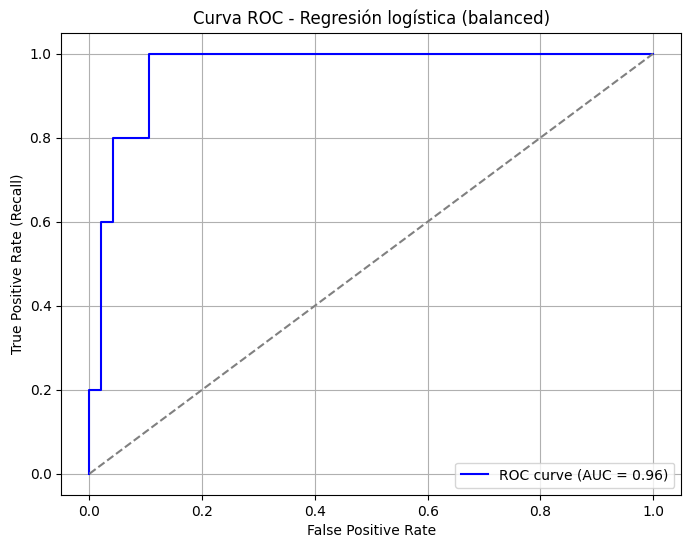

In [19]:
# probabilidades del modelo logístico
y_probs = pipeline_balanced.predict_proba(X_test)[:, 1]

# calculamos curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# vamos a verlo
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC - Regresión logística (balanced)')
plt.legend()
plt.grid(True)
plt.show()


La curva ROC (Receiver Operating Characteristic) sirve para evaluar el rendimiento de un modelo de clasificación binaria, en este caso, para predecir si una publicación será viral o no.

#### ¿Qué representa?
- **Eje X (False Positive Rate)**: Proporción de publicaciones no virales clasificadas erróneamente como virales.
- **Eje Y (True Positive Rate / Recall)**: Proporción de publicaciones virales correctamente identificadas.

- La curva ROC se aleja considerablemente de la diagonal (modelo aleatorio), lo cual indica una alta capacidad de discriminación del modelo.
- La AUC (Área bajo la curva) obtenida es 0.96, lo que significa que el modelo tiene un 96% de probabilidad de asignar una mayor probabilidad de viralidad a una publicación viral que a una no viral elegidas al azar.

#### Conclusión
- Este valor de AUC tan alto confirma que el modelo de regresión logística balanceada discrimina eficazmente entre publicaciones virales y no virales.
- La curva ROC complementa las métricas tradicionales (precisión, recall, F1-score), ofreciendo una visión global de la capacidad predictiva del modelo.


## Último modelo: Árbol de decisión

Vamos a entrenar un árbol de decisión para predecir si una publicación será viral o no, utilizando variables clave del contexto de publicación:

- `type`: tipo de contenido (Photo, Video, Status, Link)
- `paid`: si fue promocionado o no
- `post_period`: franja horaria en la que se publicó (mañana, tarde, noche)
- `post_weekday`: día de la semana
- `lifetime_post_total_reach`: alcance total del post (cuantitativa)

#### ¿Cómo funciona?

Cada nodo del árbol representa una regla basada en una de estas variables. Al seguir las bifurcaciones desde la raíz hasta una hoja, el modelo toma decisiones del tipo:

> "Si el tipo de publicación es Photo, se publicó por la noche y el alcance es mayor a cierto umbral, entonces es probable que sea viral"

#### Ventajas del modelo

- Muy visual e interpretativo.
- Permite identificar combinaciones de factores asociados a la viralidad.
- Ayuda a generar recomendaciones accionables sobre el mejor momento y formato para publicar.



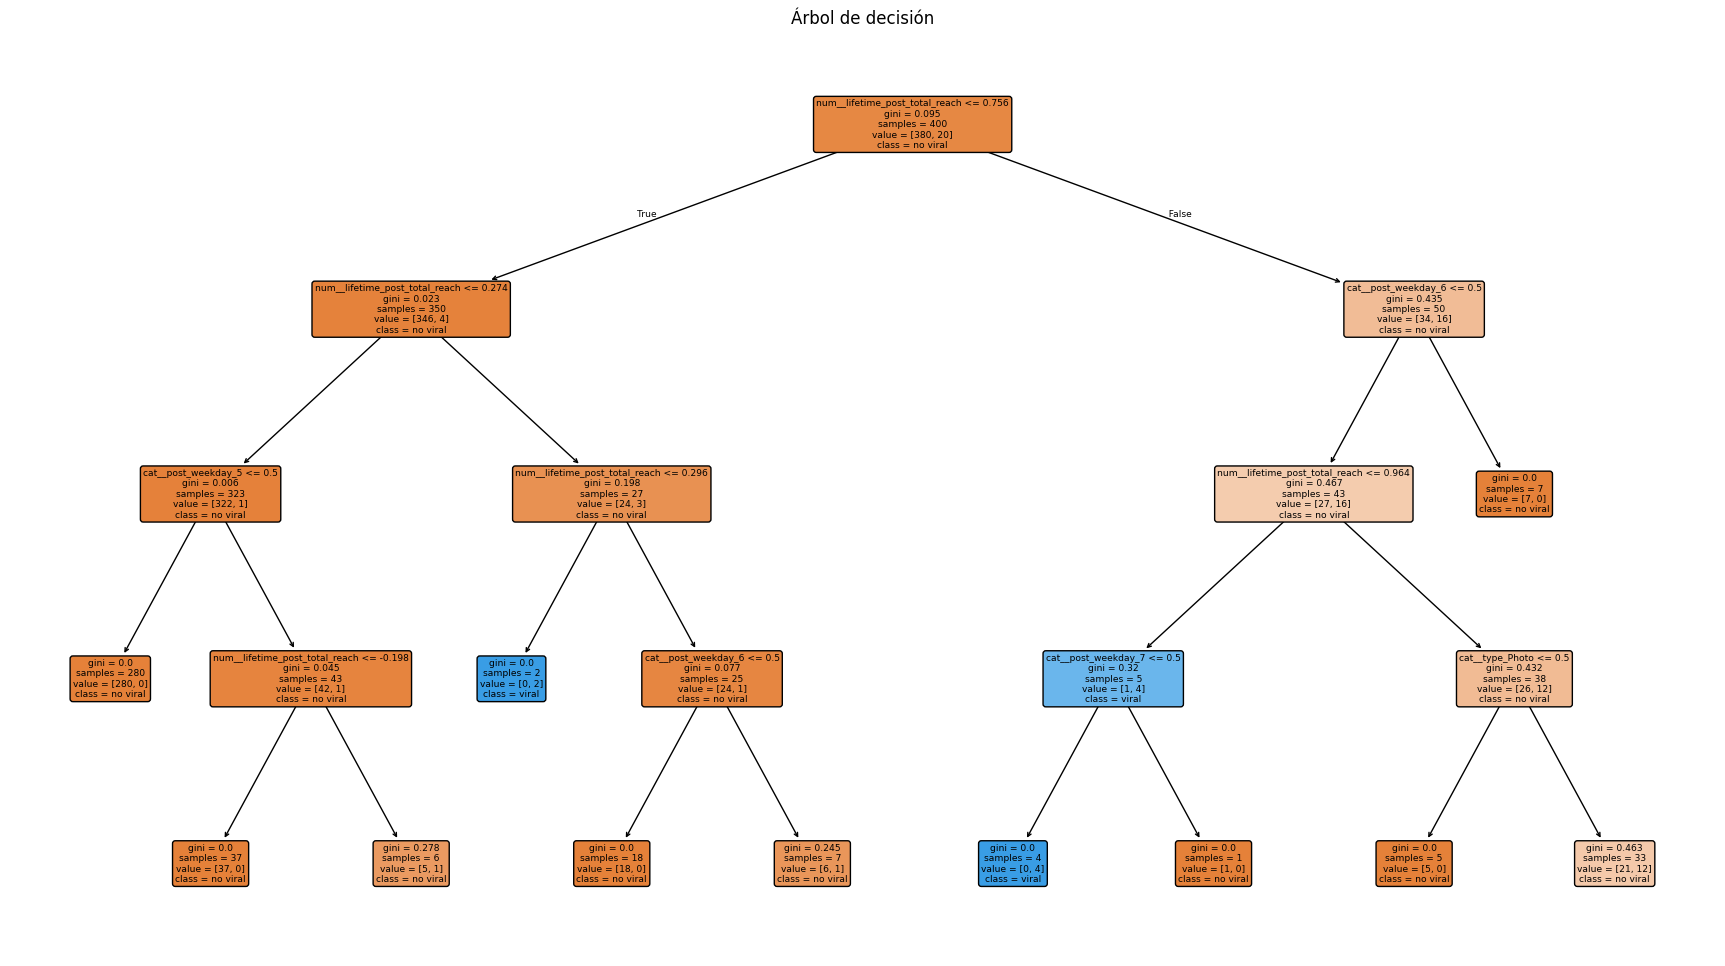

In [17]:
# 1. Selección de variables
selected_features = [
    'type',
    'paid',
    'post_period',          
    'post_weekday',
    'lifetime_post_total_reach'
]

# 2. Definir tipos de variables
numeric_features = ['lifetime_post_total_reach']
categorical_features = ['type', 'paid', 'post_period', 'post_weekday']

# 3. Preprocesador con solo las variables seleccionadas
preprocessor_tree = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# 4. Definir el pipeline del árbol
tree_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor_tree),
    ('classifier', DecisionTreeClassifier(max_depth=4, random_state=42))
])

# 5. Entrenamiento del modelo
tree_pipeline.fit(X_train[selected_features], y_train)

# 6. Visualización del árbol
plt.figure(figsize=(22, 12))
plot_tree(
    tree_pipeline.named_steps['classifier'],
    feature_names=tree_pipeline.named_steps['preprocessing'].get_feature_names_out(),
    class_names=['no viral', 'viral'],
    filled=True,
    rounded=True
)
plt.title("Árbol de decisión")
plt.show()



#### ¿Qué nos muestra el árbol?

- La variable más decisiva vuelve a ser `lifetime_post_total_reach` (alcance).
- Algunas reglas simples extraídas:
  - Si el alcance total es bajo y se publica entre semana -> casi seguro no viral.
  - Si el post tiene alto alcance, se publica ciertos días (como el domingo) y es de tipo `Photo` -> la probabilidad de viralidad aumenta.
- El modelo es capaz de aislar varios nodos puros con color azul, lo que indica alta seguridad en la predicción de viralidad para ciertos casos.

Este árbol reducido permite generar reglas claras de decisión, manteniendo el modelo simple e interpretativo. 


### Análisis de importancia de las variables

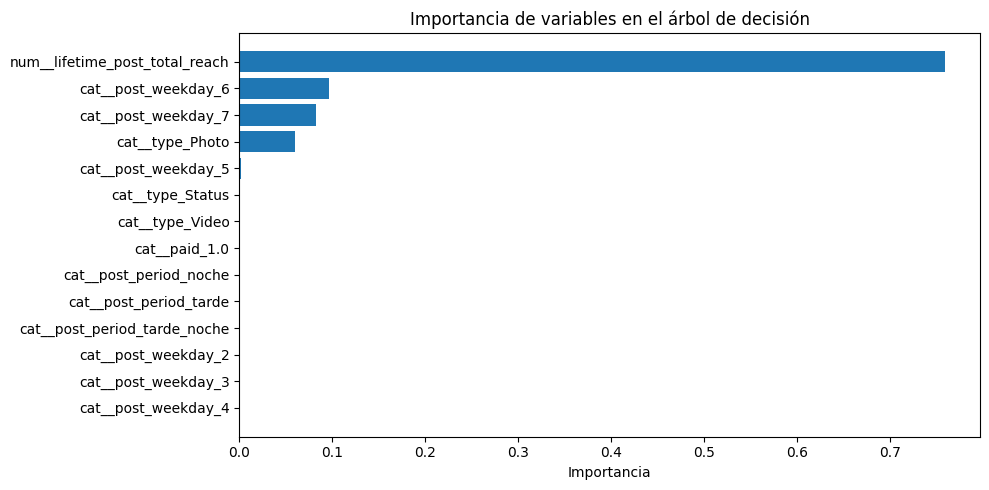

In [30]:
# obtenemos las importancias
importances = tree_pipeline.named_steps['classifier'].feature_importances_
feature_names = tree_pipeline.named_steps['preprocessing'].get_feature_names_out()

# df
importance_df = pd.DataFrame({
    'Variable': feature_names,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

# vamos a verlo
plt.figure(figsize=(10, 5))
plt.barh(importance_df['Variable'], importance_df['Importancia'])
plt.xlabel('Importancia')
plt.title('Importancia de variables en el árbol de decisión')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


El gráfico nos muestra la importancia relativa de cada variable en la construcción del árbol de decisión entrenado. Esta métrica indica cuánto contribuye cada característica a reducir la impureza (Gini) en los nodos durante la partición de los datos.

**Variables más influyentes:**

- `lifetime_post_total_reach` (alcance total): es con diferencia la variable más influyente en la predicción de si un post será viral. Tiene una importancia superior al 70%, lo que indica que el alcance orgánico de una publicación es un factor clave para su viralidad.
- `post_weekday_6` y `post_weekday_7` (sábado y domingo): los días del fin de semana parecen tener un ligero impacto en la probabilidad de que un post se vuelva viral.
- `type_Photo`: los posts con formato imagen tienden a tener más relevancia en las decisiones del modelo, aunque en menor medida.


## Conclusiones finales

En este notebook hemos evaluado dos enfoques principales para predecir la probabilidad de que una publicación sea viral:

---

#### Regresión logística penalizada con `class_weight='balanced'`

- **Ventaja principal**: logra identificar el 100% de las publicaciones virales (recall = 1.00), incluso con pocos casos positivos.
- Penaliza automáticamente la clase mayoritaria, permitiendo al modelo centrarse en detectar los casos menos frecuentes pero más relevantes.
- Ofrece métricas sólidas (accuracy = 89%) y una base estadística sólida con coeficientes interpretables mediante odds ratios.
- Ideal como modelo de referencia para tareas de clasificación en contextos desbalanceados.

---

#### Árbol de decisión 

- **Ventaja principal**: proporciona reglas claras y visuales para explicar la viralidad.
- Permite generar condiciones interpretables (por ejemplo, tipo de post + franja horaria + día).
- Aunque su precisión puede ser algo menor, es más sencillo de interpretar qué decisiones tomar.

---

### Conclusión general

> Ambos modelos se complementan eficazmente:

> - El **modelo de regresión logística penalizada** es la mejor opción cuando se busca rendimiento y capacidad de detección.
> - El **árbol de decisión** es top para comunicar resultados, definir estrategias y generar narrativas visuales.

Esta combinación cubre tanto la parte técnica como la comunicativa del análisis, aportando valor en la predicción y en la toma de decisiones.
